In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import glob
import xarray as xr
import xbudget
import regionate
import datetime
import cftime

import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import matplotlib as mpl

dpi = 100
mpl.rcParams['figure.dpi'] = dpi
sns.set_context("notebook")

import pandas as pd
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *

import xesmf as xe
from scipy import linalg
from scipy import stats
import cmocean
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from matplotlib.colors import BoundaryNorm
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
from matplotlib.patches import Rectangle

### Define helper functions 

In [3]:
def approximate_z(ds, dim = "zl"):
    tmp = ds.thkcello.cumsum(dim = dim)
    #average between 0 and cell bottom
    tmp1 = tmp.isel({dim: 0}) / 2 
    #get top of cell
    tmp2 = tmp.isel({dim : slice(0, -1)}) 
    #get bottom of cell
    tmp3 = tmp.isel({dim : slice(1, None)}) 
    #make sure cell interfaces are on same coordinate
    tmp2.coords[dim] = tmp3.coords[dim]
    #take average
    tmp4 = (tmp2 + tmp3) / 2

    ds["z"] = xr.concat([1. * tmp1, 1. * tmp4], dim = dim)    
    ds["z_bottom"] = 1. * tmp

    ds["z"] = ds["z"].where(ds["thkcello"] > 0) 
    ds["z_bottom"] = ds["z_bottom"].where(ds["thkcello"] > 0) 

    return ds

#float_conversion default is years to seconds

def integrate(ds, varname = "surface_boundary_fluxes", dim = "time", float_conversion = 3.154e+7): 
    
    # Check if time is datetime; if so, convert dt to seconds
    
    if np.issubdtype(ds[dim].dtype, np.datetime64):
        dt = da[dim].diff(dim) / np.timedelta64(1, "s")  # Convert to seconds
    elif np.issubdtype(ds[dim].dtype, "O"): 
        
        dt = ds[dim].diff(dim) / np.timedelta64(1, "s")  # Convert to seconds
    
    elif np.issubdtype((1. * ds[dim]).dtype, np.float64):
        dt = float_conversion * ds[dim].diff(dim)  # Already in numeric format (assume seconds)
    
    dt_arr = xr.zeros_like(ds[dim]) * np.nan

    dt_arr.isel({dim : slice(1, None)}).values[:] = dt.values[:]
    dt_arr = dt_arr.astype("float")

    
    trapz = (ds.shift({dim: 1})[varname] + ds[varname]) * dt_arr / 2.0
    trapz = trapz.where(~np.isnan(trapz), 0) #replace nans with zeros 

    integral_ds = xr.zeros_like(trapz).rename(f"integrated_{varname}")
    integral_ds.values = trapz.cumsum(dim).values

    return integral_ds


def linear_regression(x, y):
    """
    Compute linear regression parameters including R-squared.
    
    R-squared is calculated using: 1 - SS_residual/SS_total
    where SS_residual is sum of squared residuals from the regression line
    and SS_total is sum of squared deviations from the mean
    """
    slope, intercept, r_value, p_value, _ = stats.linregress(x, y)
    
    # Calculate R-squared
    y_pred = slope * x + intercept
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    return np.array([slope, intercept, r_value, p_value, r_squared])

def regress_spatial(spatial_data, reference_data, common_dim="time"):
    """
    Perform regression between spatial data and reference time series
    """
    # Ensure time is the first dimension for both datasets
    spatial_data = spatial_data.transpose(common_dim, ...)
    
    # Use apply_ufunc to perform regression
    results = xr.apply_ufunc(
        linear_regression,
        reference_data,
        spatial_data,
        input_core_dims=[[common_dim], [common_dim]],
        output_core_dims=[['parameter']],
        vectorize=True,
        output_dtypes=[float],
        output_sizes={'parameter': 5}  # Now 5 parameters instead of 4
    )
    
    # Create a dataset with labeled parameters
    ds = xr.Dataset({
        'slope': results.isel(parameter=0),
        'intercept': results.isel(parameter=1),
        'r_value': results.isel(parameter=2),
        'p_value': results.isel(parameter=3),
        'r_squared': results.isel(parameter=4)
    })
    
    return ds

def cftime_to_decimal_year(cftime_array):
    """Convert a cftime xarray array to a decimal year array."""
    # Extract the year, day of the year, and total days in the year
    year = cftime_array.dt.year
    day_of_year = cftime_array.dt.dayofyear
    total_days = xr.where(
        (year % 4 == 0) & ((year % 100 != 0) | (year % 400 == 0)), 366, 365
    )  # Account for leap years if necessary

    # Calculate the decimal year
    decimal_years = year + (day_of_year - 1) / total_days
    
    return decimal_years



def plot_median_quantiles(ax, x, median, lower, upper, color='blue', alpha=0.3, label=""):
    ax.plot(x, median, color=color, label=label)
    ax.fill_between(x, lower, upper, color=color, alpha=alpha)

def plot_median_with_errorbars(ax, x, median, lower, upper, color='blue', label=""):
    ax.errorbar(x, median, yerr=[median - lower, upper - median], marker='o', color=color, ecolor=color, capsize=3, label=label)

def plot_bootmedian_with_errorbars(ax, x, median, lower, upper, color='blue', label=""):
    ax.errorbar(x, median, yerr=[median - lower, upper - median], marker='o', color=color, ecolor=color, capsize=3, label=label)
    

In [4]:
def bootstrap_spatial_stats(da, n_bootstrap=5000, flat_coords = ["xh", "yh"], seed=None):
    """
    Calculate bootstrapped mean and standard error for spatial data.
    
    Parameters:
    -----------
    da : xarray.DataArray
        Input spatial data array
    n_bootstrap : int, optional
        Number of bootstrap samples to generate
    seed : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    xarray.Dataset
        Dataset containing the bootstrapped statistics:
        - original_mean: spatial mean of original data
        - original_std: spatial standard deviation of original data
        - boot_mean: mean of bootstrapped means
        - boot_std: standard deviation of bootstrapped means (standard error)
        - confidence_intervals: 95% confidence intervals for the mean
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Flatten spatial dimensions into a single dimension
    
    stacked_da = da.stack(space=flat_coords)
    stacked_da = stacked_da.where(~np.isnan(stacked_da), drop=True)

    # .dropna(dim = "space", how='all')
    
    # Original statistics
    orig_mean = stacked_da.mean('space')
    orig_std = stacked_da.std('space')
    
    # Preallocate array for bootstrap samples
    boot_means = np.zeros((n_bootstrap,) + orig_mean.shape)
    
    # Perform bootstrap sampling
    for i in range(n_bootstrap):
        # Sample with replacement
        n_points = len(stacked_da.space)
        indices = np.random.randint(0, n_points, size=n_points)
        boot_sample = stacked_da.isel(space=indices)
        
        # Calculate mean for this bootstrap sample
        boot_means[i] = boot_sample.mean('space').values
    
    # Convert bootstrap results to xarray
    boot_means_da = xr.DataArray(
        boot_means,
        dims=('bootstrap',) + orig_mean.dims,
        coords={'bootstrap': range(n_bootstrap), **orig_mean.coords}
    )
    
    # Calculate bootstrap statistics
    bootstrap_mean = boot_means_da.mean('bootstrap')
    bootstrap_std = boot_means_da.std('bootstrap')
    
    # # Calculate 95% confidence intervals
    # ci_lower = np.percentile(boot_means, 2.5, axis=0)
    # ci_upper = np.percentile(boot_means, 97.5, axis=0)
    try: 
        ci_lower = boot_means_da.quantile(0.025, dim='bootstrap').values
    
        ci_upper = boot_means_da.quantile(0.975, dim='bootstrap').values
    except: 
        print(boot_means_da)
    
    if np.isnan(np.sum(ci_upper)):
        print("something is wrong^^^^^^")
        
        print("printing sum of bootmean:", np.sum(boot_means))
        print("printing sum of data:", np.sum(stacked_da))

    # Combine results into a dataset
    results = xr.Dataset({
        'original_mean': orig_mean,
        'original_std': orig_std,
        'boot_mean': bootstrap_mean,
        'boot_std': bootstrap_std,
        'ci_lower': (orig_mean.dims, ci_lower),
        'ci_upper': (orig_mean.dims, ci_upper)
    })
    
    return results

In [5]:
def _bootstrap_single_snapshot(data, n_bootstrap=5000, seed=None):
    """
    Helper function to bootstrap a single spatial snapshot.
    Expects numpy array of clean data (no NaNs).
    
    Parameters:
    -----------
    data : numpy.ndarray
        Clean 1D array of data points
    n_bootstrap : int
        Number of bootstrap samples
    seed : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    np.ndarray
        Array of statistics [orig_mean, orig_std, boot_mean, boot_std, ci_lower, ci_upper]
    """
    if seed is not None:
        np.random.seed(seed)
    data = data[~np.isnan(data)]
    if len(data) == 0:  # Handle case where all data is NaN
        return np.array([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
    
    n_points = len(data)
    boot_means = np.zeros(n_bootstrap)
    
    # Perform bootstrap sampling
    for i in range(n_bootstrap):
        indices = np.random.randint(0, n_points, size=n_points)
        boot_sample = data[indices]
        boot_means[i] = np.mean(boot_sample)
    
    # Calculate statistics
    orig_mean = np.mean(data)
    orig_std = np.std(data)
    boot_mean = np.mean(boot_means)
    boot_std = np.std(boot_means)
    ci_lower = np.percentile(boot_means, 2.5)
    ci_upper = np.percentile(boot_means, 97.5)
    
    return np.array([orig_mean, orig_std, boot_mean, boot_std, ci_lower, ci_upper])

def bootstrap_spatial_stats_broadcast(da, n_bootstrap=5000, flat_coords=["xh", "yh"], seed=None):
    """
    Calculate bootstrapped mean and standard error for spatial data.
    Uses xarray's apply_ufunc for automatic broadcasting across non-spatial dimensions.
    
    Parameters:
    -----------
    da : xarray.DataArray
        Input spatial data array
    n_bootstrap : int, optional
        Number of bootstrap samples to generate
    flat_coords : list of str, optional
        List of coordinate names to flatten for spatial sampling
    seed : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    xarray.Dataset
        Dataset containing the bootstrapped statistics:
        - original_mean: spatial mean of original data
        - original_std: spatial standard deviation of original data
        - boot_mean: mean of bootstrapped means
        - boot_std: standard deviation of bootstrapped means (standard error)
        - ci_lower: lower bound of 95% confidence interval
        - ci_upper: upper bound of 95% confidence interval
    """
    # Stack spatial dimensions
    stacked_da = da.stack(space=flat_coords)
    
    # Define output names for the statistics
    stat_names = ['original_mean', 'original_std', 'boot_mean', 
                  'boot_std', 'ci_lower', 'ci_upper']
    
    # Apply the bootstrap function across non-spatial dimensions
    result = xr.apply_ufunc(
        _bootstrap_single_snapshot,
        stacked_da,
        input_core_dims=[['space']],
        output_core_dims=[['stat']],
        vectorize=True,
        kwargs={'n_bootstrap': n_bootstrap, 
               'seed': seed},
        dask='parallelized',
        output_dtypes=[float],
        output_sizes={'stat': 6}
    )
    
    # Convert to dataset with named variables
    result = result.assign_coords(stat=stat_names)
    ds = result.to_dataset(dim='stat')
    
    return ds

In [6]:
sigma = 37.00
toSv = 1/1035*1e-6
toTg = 1e-9 

mass_flux_units = "Tg/s"
mass_flux_units_conversion = toTg

expt_colors = dict(); expt_colors["control"] = "#2f74b3"; expt_colors["forced"] = "#cc415a"

ds = xr.open_dataset(
        datadir("/model/Southern_Ocean_WMT_Budget.nc"))
ds["surface_boundary_fluxes"] = ds["boundary_fluxes"] - ds["bottom_flux_heat"]
ds = ds.sel(sigma2_l_target = sigma, method = "nearest")

ds_integrated = integrate(ds, "surface_boundary_fluxes")

yearly_average = lambda ds: ds.groupby("time.year").mean("time")
ds_columns_forced = xr.open_dataset(
        datadir("/model/Tracer_Columns_Bottom250_forced.nc"))

ds_columns_control = xr.open_dataset(
        datadir("/model/Tracer_Columns_Bottom250_control.nc"))
ds_columns_control.coords['time'] = ds_columns_forced.time.values

ds_columns = xr.concat([
    yearly_average(ds_columns_forced).expand_dims(exp=['forced']),
    yearly_average(ds_columns_control).expand_dims(exp=['control'])
], dim='exp')

In [7]:
ds_GLODAPP = xr.open_dataset("GLODAP_gridded.nc")
regridder = xe.Regridder(ds_columns, ds_GLODAPP, "bilinear", periodic = True)
ds_GLODAPP["deptho"] = regridder(ds_columns_control["deptho"])
ds_GLODAPP["deptho"]  = ds_GLODAPP["deptho"].where(ds_GLODAPP["deptho"] > 0)

bottom_GLODAPP = ds_GLODAPP["G2cfc11"].where(np.abs(ds_GLODAPP["deptho"] - ds_GLODAPP["z"]) < 250)
bottom_GLODAPP = bottom_GLODAPP.mean("z")
bottom_GLODAPP = bottom_GLODAPP.count("time") > 1
bottom_GLODAPP = bottom_GLODAPP.where(bottom_GLODAPP > 0)

In [8]:
cfc11_arrival = xr.where(ds_columns.cfc11 >= 0.01, 1, 0)
cfc11_arrival = cfc11_arrival * 1. * cfc11_arrival.year
cfc11_arrival = cfc11_arrival.where(cfc11_arrival > 0)
cfc11_arrival = cfc11_arrival.min(dim = "year", skipna = True)

### Plotting CFC-11 Arrival Time

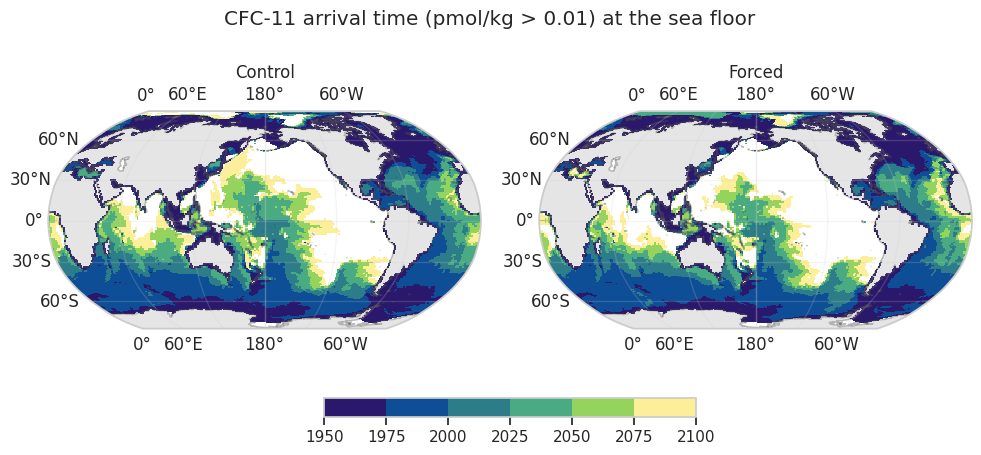

In [9]:
import matplotlib.patches as  mpath
from matplotlib.colors import BoundaryNorm, ListedColormap
import cartopy.feature as cfeature
import cmocean.cm as cmo

fig, ax = plt.subplots(1, 2, figsize = (10, 5),
                        subplot_kw={'projection':ccrs.Robinson(central_longitude = 180)})

arrival_levels = np.arange(1950, 2100.1, 25)  
arrival_levels[np.abs(arrival_levels) < 1e-16]  = 0
cmap = plt.get_cmap(cmo.haline)
norm = BoundaryNorm(arrival_levels, ncolors=cmap.N, clip=False)

ax[0].pcolormesh(cfc11_arrival.geolon, cfc11_arrival.geolat, 
                 cfc11_arrival.sel(exp = "control"), 
                 transform = ccrs.PlateCarree(), 
                 cmap = cmap, norm = norm)

ax[0].set_title("Control")

cb = ax[1].pcolormesh(cfc11_arrival.geolon, cfc11_arrival.geolat, 
                 cfc11_arrival.sel(exp = "forced"), 
                 transform = ccrs.PlateCarree(), 
                 cmap = cmap, norm = norm)
ax[1].set_title("Forced")
[a.coastlines(resolution = "50m", alpha = 0.2) for a in ax]

gl = ax[0].gridlines(draw_labels = True, alpha = 0.2); gl.top_label = False; gl.bottom_label = False
ax[0].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey', alpha = 0.2))

gl = ax[1].gridlines(draw_labels = True, alpha = 0.2)
ax[1].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey', alpha = 0.2))

fig.tight_layout()
fig.suptitle("CFC-11 arrival time (pmol/kg > 0.01) at the sea floor", y = 0.85)
fig.colorbar(cb, ax = ax[:2], orientation = "horizontal", fraction = 0.04)


In [26]:
yearly_average = lambda ds: ds.groupby("time.year").mean("time")
yearly_std = lambda ds: ds.groupby("time.year").std("time")

ds_columns_forced = xr.open_dataset(
        datadir("/model/Tracer_Columns_Bottom250_forced.nc"))

ds_columns_control = xr.open_dataset(
        datadir("/model/Tracer_Columns_Bottom250_control.nc"))
ds_columns_control.coords['time'] = ds_columns_forced.time.values

ds_columns = xr.concat([
    ds_columns_forced.expand_dims(exp=['forced']),
    ds_columns_control.expand_dims(exp=['control'])
], dim='exp').compute()


ds_columns = ds_columns.drop_vars(["lat", "lon"]).rename({"geolon":"lon", "geolat":"lat"})

ds_GLODAPP = xr.open_dataset("GLODAP_gridded.nc")

regridder = xe.Regridder(ds_columns, ds_GLODAPP, "bilinear", periodic = True)
ds_columns = regridder(ds_columns)
ds_columns["deptho"] = regridder(ds_columns_control["deptho"])

del ds_columns_forced, ds_columns_control

In [38]:
ds_GLODAPP["deptho"] = ds_columns["deptho"]
ds_GLODAPP["deptho"]  = ds_GLODAPP["deptho"].where(ds_GLODAPP["deptho"] > 0)

bottom_cfc11 = ds_GLODAPP["G2cfc11"].where(np.abs(ds_GLODAPP["deptho"] - ds_GLODAPP["z"]) < 250)
bottom_cfc11 = bottom_cfc11.mean("z")

glodap_mask = 1. * (bottom_cfc11.count("time") > 0)
glodap_mask = glodap_mask.where(glodap_mask > 0)

masked_glodap_model = ds_columns.cfc11 * glodap_mask
masked_glodap_model.coords['time'] = cftime_to_decimal_year(masked_glodap_model.time).values

NameError: name 'masked_glodap_model' is not defined

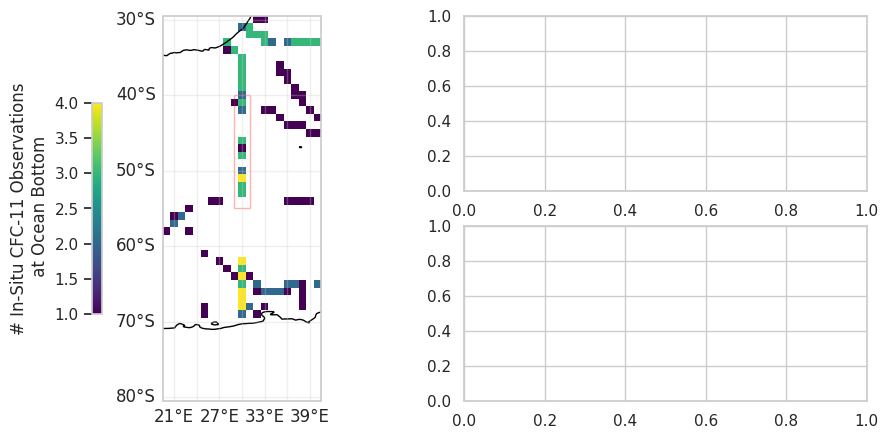

In [59]:
# Initialize GridSpec layout
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(2, 2, width_ratios=[1.5, 2])

# Observation count plot
obs_ax = fig.add_subplot(gs[:, 0], projection=ccrs.PlateCarree())
# Stacked line plots
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 1], sharex=ax1)

obs_count = ((~np.isnan(bottom_cfc11)).sum("time")).sel(lat=slice(-80, -30), lon=slice(20, 40)).T
obs_count = obs_count.where(obs_count > 0)
# levels = np.arange(0, obs_count.max() + 1, 1)
cb = obs_count.plot(ax=obs_ax, cmap="viridis", add_colorbar=True, 
                    transform = ccrs.PlateCarree(), 
                   cbar_kwargs = {"location":"left", "fraction":0.035, 
                                  "pad" : 0.2, "label":"# In-Situ CFC-11 Observations\n at Ocean Bottom"})
obs_ax.coastlines()
gl = obs_ax.gridlines(draw_labels = True, alpha = 0.3)
gl.right_labels = False
gl.top_labels = False

# fig.colorbar(cb, ax=obs_ax, orientation="vertical", label="Observation Count", ticks=levels)
# obs_ax.set_title("Observation Counts in Specified Region")

# Add a red box for the specified region
locations = {"lat": slice(-55, -40), "lon": slice(29, 31)}
lat_min, lat_max = locations["lat"].start, locations["lat"].stop
lon_min, lon_max = locations["lon"].start, locations["lon"].stop
obs_ax.add_patch(Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                           edgecolor='red', facecolor='none', lw=1, alpha = 0.3,
                           transform=ccrs.PlateCarree()))


data_labels, data_colors = ["CM4Xp125 forced", "CM4Xp125 control", "GLODAP"], ["red", "blue", "green"]
datasets = [masked_glodap_model.sel(locations).isel(exp=i) for i in range(2)] + [bottom_cfc11]

for label, color, dataset in zip(data_labels, data_colors, datasets):
    data_selected = dataset.sel(locations)
    median = data_selected.quantile(0.5, dim=["lat", "lon"])
    lower, upper = data_selected.quantile(0.025, dim=["lat", "lon"]), data_selected.quantile(0.975, dim=["lat", "lon"])
    if label == "GLODAP":
        plot_median_with_errorbars(ax1, data_selected.time, median, lower, upper, color=color, label=label)
        print(data_selected.count(dim=["lat", "lon"]).values[~np.isnan(data_selected.count(dim=["lat", "lon"]).values)])
        ax2.scatter(data_selected.time, data_selected.count(dim=["lat", "lon"]), 
                    color=color, label=label, marker = "o", zorder = 10)
    else:
        plot_median_quantiles(ax1, data_selected.time, median, lower, upper, color=color, label=label)

ax2.scatter(datasets[0].time, datasets[0].sel(locations).count(dim=["lat", "lon"]).where(lambda x: x > 0), color="k", label="model")

# Finalize plot details
ax1.set_ylabel('CFC-11 Concentration')
ax1.legend()

ax2.set_xlabel('Time')
ax2.set_ylabel('Number of Observations')
ax2.legend()

fig.tight_layout()

In [73]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import numpy as np
from matplotlib.patches import Rectangle
from matplotlib.colors import BoundaryNorm

def plot_cfc11_analysis(bottom_cfc11, masked_glodap_model, plot_median_with_errorbars, plot_median_quantiles, 
                       region={"lat": slice(-55, -45), "lon": slice(29, 31)},
                       obs_region={"lat": slice(-80, -30), "lon": slice(20, 40)},
                       figsize=(10, 5)):
    """
    Create a comprehensive visualization of CFC-11 data analysis with observation counts and time series.
    Uses a discrete colorbar with colors centered on integer values.
    """
    # Initialize GridSpec layout
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 2, width_ratios=[1.5, 2])
    
    # Observation count plot
    obs_ax = fig.add_subplot(gs[:, 0], projection=ccrs.PlateCarree())
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[1, 1], sharex=ax1)
    
    # Calculate observation counts
    obs_count = ((~np.isnan(bottom_cfc11)).sum("time")).sel(
        lat=slice(obs_region["lat"].start, obs_region["lat"].stop),
        lon=slice(obs_region["lon"].start, obs_region["lon"].stop)
    ).T
    obs_count = obs_count.where(obs_count > 0)
    
    # Create boundaries halfway between integers
    max_count = int(np.ceil(obs_count.max().values))
    min_count = int(np.floor(obs_count.min().values)) if not np.isnan(obs_count.min()) else 0
    
    # Create boundaries array (halfway between integers)
    boundaries = np.arange(min_count - 0.5, max_count + 1.5, 1)
    # Create the levels for the tick marks (integers)
    levels = np.arange(min_count, max_count + 1, 1)
    
    # Create the discrete colormap
    cmap = plt.cm.viridis
    norm = BoundaryNorm(boundaries, cmap.N)
    
    # Plot with discrete colorbar
    mesh = obs_ax.pcolormesh(
        obs_count.lon, 
        obs_count.lat, 
        obs_count.values,
        cmap=cmap,
        norm=norm,
        transform=ccrs.PlateCarree()
    )
    
    # Add colorbar
    cb = plt.colorbar(
        mesh,
        ax=obs_ax,
        orientation="vertical",
        label="# In-Situ CFC-11 Observations\nat Ocean Bottom",
        ticks=levels,  # use integer levels for tick marks
        boundaries=boundaries,  # use boundaries for color transitions
        pad=0.2,
        fraction=0.035,
        location="left"
    )
    
    # Configure map
    obs_ax.coastlines()
    gl = obs_ax.gridlines(draw_labels=True, alpha=0.3)
    gl.right_labels = False
    gl.top_labels = False
    
    # Add analysis region box
    lat_min, lat_max = region["lat"].start, region["lat"].stop
    lon_min, lon_max = region["lon"].start, region["lon"].stop
    obs_ax.add_patch(Rectangle(
        (lon_min, lat_min),
        lon_max - lon_min,
        lat_max - lat_min,
        edgecolor='red',
        facecolor='none',
        lw=1,
        alpha=0.3,
        transform=ccrs.PlateCarree()
    ))
    
    # Plot time series
    data_labels = ["CM4Xp125 forced", "CM4Xp125 control", "GLODAP"]
    data_colors = ["red", "blue", "green"]
    datasets = [masked_glodap_model.sel(region).isel(exp=i) for i in range(2)] + [bottom_cfc11]
    
    for label, color, dataset in zip(data_labels, data_colors, datasets):
        data_selected = dataset.sel(region)
        median = data_selected.quantile(0.5, dim=["lat", "lon"])
        lower = data_selected.quantile(0.025, dim=["lat", "lon"])
        upper = data_selected.quantile(0.975, dim=["lat", "lon"])
        
        if label == "GLODAP":
            plot_median_with_errorbars(ax1, data_selected.time, median, lower, upper,
                                     color=color, label=label)
            ax2.scatter(data_selected.time,
                       data_selected.count(dim=["lat", "lon"]),
                       color=color, label=label, marker="o", zorder=10)
        else:
            plot_median_quantiles(ax1, data_selected.time, median, lower, upper,
                                color=color, label=label)
    
    # Add model observation counts
    ax2.scatter(
        datasets[0].time,
        datasets[0].sel(region).count(dim=["lat", "lon"]).where(lambda x: x > 0),
        color="k",
        label="model"
    )
    
    # Finalize plot details
    ax1.set_ylabel('CFC-11 Concentration')
    ax1.legend()
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Number of Observations')
    ax2.legend()
    fig.tight_layout()
    
    return fig

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


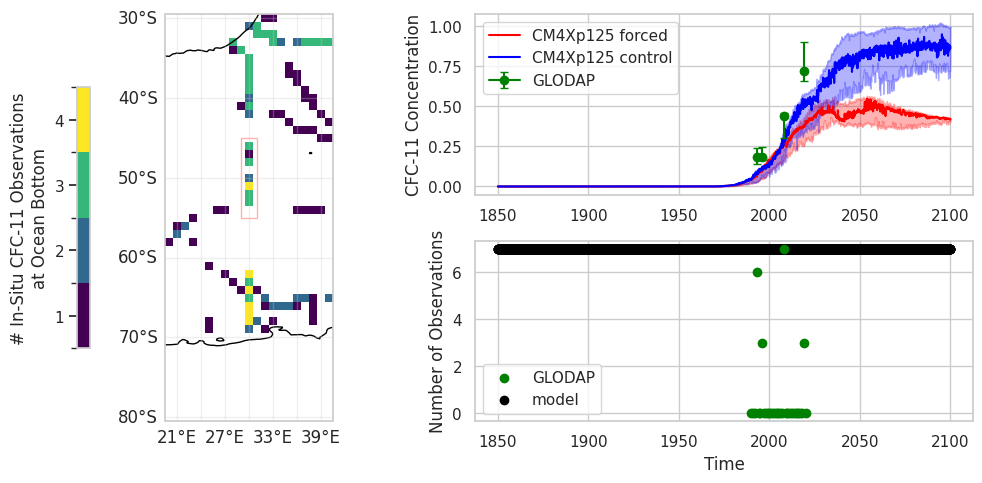

In [74]:
region={"lat": slice(-55, -45), "lon": slice(29, 31)}
obs_region={"lat": slice(-80, -30), "lon": slice(20, 40)}

fig = plot_cfc11_analysis(
    bottom_cfc11=bottom_cfc11,
    masked_glodap_model=masked_glodap_model,
    plot_median_with_errorbars=plot_median_with_errorbars,
    plot_median_quantiles=plot_median_quantiles, 
    region = region, 
    obs_region = obs_region
)
plt.show()

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


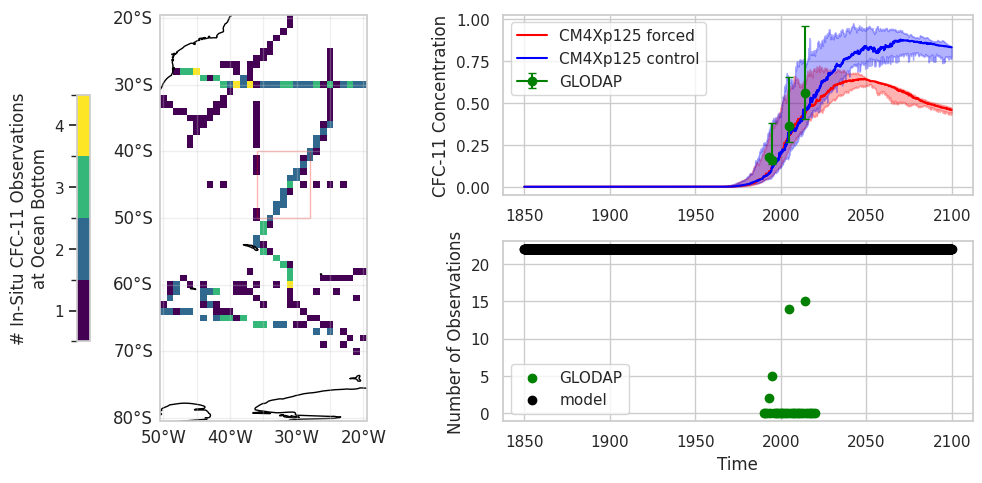

In [72]:
region={"lat": slice(-50, -40), "lon": slice(-36, -28)}
obs_region={"lat": slice(-80, -20), "lon": slice(-50, -20)}

fig = plot_cfc11_analysis(
    bottom_cfc11=bottom_cfc11,
    masked_glodap_model=masked_glodap_model,
    plot_median_with_errorbars=plot_median_with_errorbars,
    plot_median_quantiles=plot_median_quantiles, 
    region = region, 
    obs_region = obs_region
)
plt.show()

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


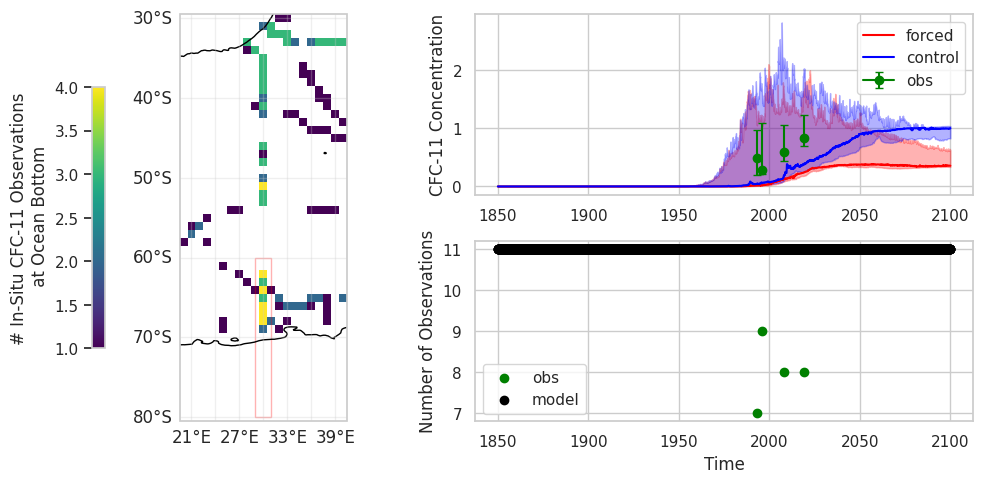

In [189]:
# Initialize GridSpec layout
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(2, 2, width_ratios=[1.5, 2])

# Observation count plot
obs_ax = fig.add_subplot(gs[:, 0], projection=ccrs.PlateCarree())
# Stacked line plots
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 1], sharex=ax1)

obs_count = ((~np.isnan(bottom_cfc11)).sum("time")).sel(lat=slice(-80, -30), lon=slice(20, 40)).T
obs_count = obs_count.where(obs_count > 0)
# levels = np.arange(0, obs_count.max() + 1, 1)
cb = obs_count.plot(ax=obs_ax, cmap="viridis", add_colorbar=True, 
                    transform = ccrs.PlateCarree(), 
                   cbar_kwargs = {"location":"left", "fraction":0.035, 
                                  "pad" : 0.2, "label":"# In-Situ CFC-11 Observations\n at Ocean Bottom"})
obs_ax.coastlines()
gl = obs_ax.gridlines(draw_labels = True, alpha = 0.3)
gl.right_labels = False
gl.top_labels = False

# fig.colorbar(cb, ax=obs_ax, orientation="vertical", label="Observation Count", ticks=levels)
# obs_ax.set_title("Observation Counts in Specified Region")

# Add a red box for the specified region
locations = {"lat": slice(-80, -60), "lon": slice(29, 31)}
lat_min, lat_max = locations["lat"].start, locations["lat"].stop
lon_min, lon_max = locations["lon"].start, locations["lon"].stop
obs_ax.add_patch(Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                           edgecolor='red', facecolor='none', lw=1, alpha = 0.3,
                           transform=ccrs.PlateCarree()))


data_labels, data_colors = ["forced", "control", "obs"], ["red", "blue", "green"]
datasets = [masked_glodap_model.sel(locations).isel(exp=i) for i in range(2)] + [bottom_cfc11]

for label, color, dataset in zip(data_labels, data_colors, datasets):
    data_selected = dataset.sel(locations)
    median = data_selected.quantile(0.5, dim=["lat", "lon"])
    lower, upper = data_selected.quantile(0.025, dim=["lat", "lon"]), data_selected.quantile(0.975, dim=["lat", "lon"])
    if label == "obs":
        plot_median_with_errorbars(ax1, data_selected.time, median, lower, upper, color=color, label=label)
        ax2.scatter(data_selected.time, data_selected.count(dim=["lat", "lon"]).where(lambda x: x > 0), color=color, label=label)
    else:
        plot_median_quantiles(ax1, data_selected.time, median, lower, upper, color=color, label=label)

ax2.scatter(datasets[0].time, datasets[0].sel(locations).count(dim=["lat", "lon"]), color="k", label="model")

# Finalize plot details
ax1.set_ylabel('CFC-11 Concentration')
ax1.legend()

ax2.set_xlabel('Time')
ax2.set_ylabel('Number of Observations')
ax2.legend()

fig.tight_layout()

### Determining Emergence

In [93]:
yearly_average = lambda ds: ds.groupby("time.year").mean("time")
yearly_std = lambda ds: ds.groupby("time.year").std("time")

ds_columns_forced = xr.open_dataset(
        datadir("/model/Tracer_Columns_Bottom250_forced.nc"))

ds_columns_control = xr.open_dataset(
        datadir("/model/Tracer_Columns_Bottom250_control.nc"))
ds_columns_control.coords['time'] = ds_columns_forced.time.values

ds_columns = xr.concat([
    ds_columns_forced.expand_dims(exp=['forced']),
    ds_columns_control.expand_dims(exp=['control'])
], dim='exp').compute()


ds_columns = ds_columns.drop_vars(["lat", "lon"]).rename({"geolon":"lon", "geolat":"lat"})

ds_GLODAPP = xr.open_dataset("GLODAP_gridded.nc")

regridder = xe.Regridder(ds_columns, ds_GLODAPP, "bilinear", periodic = True)
ds_columns = regridder(ds_columns)
ds_columns["deptho"] = regridder(ds_columns_control["deptho"])

del ds_columns_forced, ds_columns_control

In [94]:
ds_GLODAPP["deptho"] = ds_columns["deptho"]
ds_GLODAPP["deptho"]  = ds_GLODAPP["deptho"].where(ds_GLODAPP["deptho"] > 0)

bottom_cfc11 = ds_GLODAPP["G2cfc11"].where(np.abs(ds_GLODAPP["deptho"] - ds_GLODAPP["z"]) < 250)
bottom_cfc11 = bottom_cfc11.mean("z")

In [95]:
glodap_mask = 1. * (bottom_cfc11.count("time") > 0)
glodap_mask = glodap_mask.where(glodap_mask > 0)
bottom_GLODAPP_CM4X_mask = glodap_mask.where((glodap_mask.lat < -40) *\
                                                          (glodap_mask.lat > -60))
bottom_GLODAPP_CM4X_notmask = xr.where(np.isnan(bottom_GLODAPP_CM4X_mask) * ~np.isnan(glodap_mask), 1, np.nan)

Glon, Glat = np.meshgrid(bottom_GLODAPP_CM4X_mask.lon, bottom_GLODAPP_CM4X_mask.lat)
Glon = Glon.flatten()
Glat = Glat.flatten()

In [96]:
masked_model_bottom = ds_columns[["cfc11", "thetao"]] * bottom_GLODAPP_CM4X_mask

masked_cfcs = ds_columns["cfc11"] * bottom_GLODAPP_CM4X_mask
masked_cfcs.coords['time'] = cftime_to_decimal_year(masked_cfcs.time).values
masked_cfcs = masked_cfcs.sel(time = slice("1950", None))
boot_cfcs = xr.concat([
            bootstrap_spatial_stats(masked_cfcs.isel(exp = 0), n_bootstrap=1000, flat_coords = ["lon", "lat"]),
            bootstrap_spatial_stats(masked_cfcs.isel(exp = 1), n_bootstrap=1000, flat_coords = ["lon", "lat"])], 
            dim = "exp")

In [97]:
time_mask = xr.where(~np.isnan(bottom_cfc11), 1, np.nan) * bottom_GLODAPP_CM4X_mask

In [98]:
sparse_datasets = []
for yr in np.unique(ds_columns.time.dt.year):
    int_yr = int(yr)
    if int_yr in bottom_cfc11.time.values:
        masked_values = ds_columns["cfc11"].sel(time = str(int_yr)) * time_mask.sel(time = int_yr)
        sparse_datasets += [1 * masked_values]
masked_cfcs_sparse = xr.concat(sparse_datasets, dim = "time"); del sparse_datasets
masked_cfcs_sparse.coords['time'] = cftime_to_decimal_year(masked_cfcs_sparse.time).values
masked_cfcs_sparse = masked_cfcs_sparse.sel(time = slice("1950", None))
boot_cfcs_sparse = xr.concat([
            bootstrap_spatial_stats_broadcast(masked_cfcs_sparse.isel(exp = 0), n_bootstrap=1000, flat_coords = ["lon", "lat"]),
            bootstrap_spatial_stats_broadcast(masked_cfcs_sparse.isel(exp = 1), n_bootstrap=1000, flat_coords = ["lon", "lat"])], 
            dim = "exp")

/tmp/ipykernel_83930/1403940735.py:80: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
/tmp/ipykernel_83930/1403940735.py:80: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(


In [99]:
bottom_cfc11_stats = bootstrap_spatial_stats_broadcast(bottom_cfc11.sel(lat = slice(-60, -40)), n_bootstrap=5000, flat_coords = ["lon", "lat"])
bottom_cfc11_stats = bottom_cfc11_stats.sortby("time")                        

/tmp/ipykernel_83930/1403940735.py:80: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(


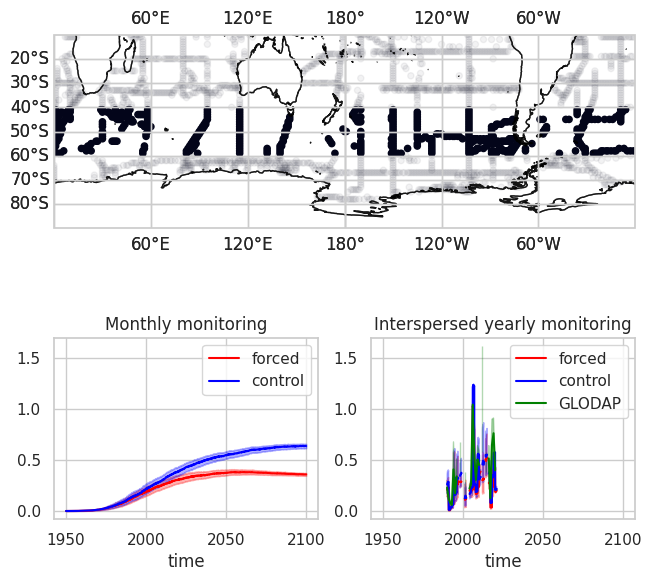

In [100]:
# Set up a custom GridSpec layout with controlled row heights
fig = plt.figure(figsize=(7.5, 7.5))
gs = gridspec.GridSpec(6, 2)

# Line plot taking up the entire left column
line_ax = fig.add_subplot(gs[4:, 0])  # Span both rows in the left column
exps = ["forced", "control"]
cs = ["r", "b"]
for (i, exp) in enumerate(exps):
    # Plot bootstrap results
    boot_cfcs.boot_mean.sel(exp = exp).plot(ax=line_ax, label=exp, color=cs[i])
    line_ax.fill_between(boot_cfcs.sel(exp = exp).time, 
                     boot_cfcs.sel(exp = exp).ci_lower, 
                     boot_cfcs.sel(exp = exp).ci_upper, 
                     alpha=0.3, 
                     color=cs[i])
line_ax.set_title("Monthly monitoring")
line_ax.set_xlabel("time")
line_ax.set_ylabel("")
line_ax.legend()

line_ax2 = fig.add_subplot(gs[4:, 1], sharey = line_ax, sharex = line_ax)  # Span both rows in the left column
for (i, exp) in enumerate(exps):
    # Plot bootstrap results
    boot_cfcs_sparse.boot_mean.sel(exp = exp).plot(ax=line_ax2, label=exp, color=cs[i])
    line_ax2.fill_between(boot_cfcs_sparse.sel(exp = exp).time, 
                     boot_cfcs_sparse.sel(exp = exp).ci_lower, 
                     boot_cfcs_sparse.sel(exp = exp).ci_upper, 
                     alpha=0.3, 
                     color=cs[i])
    
bottom_cfc11_stats.boot_mean.plot(ax=line_ax2, label="GLODAP", c = "g")
line_ax2.fill_between(bottom_cfc11_stats.time, 
                 bottom_cfc11_stats.ci_lower, 
                 bottom_cfc11_stats.ci_upper, 
                 alpha=0.3, 
                 color="g")
line_ax.legend()

line_ax2.set_title("Interspersed yearly monitoring")
line_ax2.set_xlabel("time")
line_ax2.set_ylabel("")
line_ax2.legend()



# line_ax.set_title("PC1 of CFC-11 Response to CO2 Emissions")

# Function to create a map with colorbar and scatter points
def plot_map(ax, data, title, alpha = 0.2):
    ax.set_global()
    ax.set_extent([-180, 180, -10, -90], crs=ccrs.PlateCarree(central_longitude=180))
    ax.scatter(Glon, Glat, c=data, transform=ccrs.PlateCarree(), s=20, alpha=alpha)
    ax.set_title(title)
    ax.coastlines(resolution="50m", alpha=0.7)
    ax.set_aspect(1.5)
    ax.gridlines(draw_labels=True)

# Top and bottom maps in the second column
map_ax1 = fig.add_subplot(gs[0:4, :], projection=ccrs.PlateCarree(central_longitude=180))
plot_map(map_ax1, bottom_GLODAPP_CM4X_mask.T.values.flatten(), "", alpha = 1)
plot_map(map_ax1, bottom_GLODAPP_CM4X_notmask.T.values.flatten(), "", alpha = 0.05)

### Taking the EOF of the difference between climate scenarios (i.e. finding the fingerprint) 

In [191]:
dstime = xr.open_dataset(
        datadir("/model/Tracer_Columns_Bottom250_forced.nc")).time

model_diff = -masked_model_bottom["cfc11"].diff("exp").isel(exp = 0).drop_vars("exp").expand_dims(exp=['difference'])
model_diff.coords['time'] = dstime.time.values
model_diff = yearly_average(model_diff).isel(exp = 0)
model_diff = model_diff.isel(lat = slice(30, 49))

#define data matrix (time, locations) 
Y = 1  * model_diff.values.reshape((len(model_diff["year"]), -1)).T
whereYnan = np.isnan(1 * Y); Y[whereYnan] = 0.0

#take svd of data matrix 
U, s, Vh = linalg.svd(Y, full_matrices = True)

var_exp = 100 * s * s / np.sum(s * s)
var_exp = np.round(var_exp, decimals = 1)

EOF1 = U[:, 0:1] 
PC1 = (EOF1.T @ Y).flatten()
PC1 = (PC1 - PC1.mean()) / PC1.std()

xPC1 = 1 * model_diff.isel(lat = 0, lon = 0).drop_vars(["lat", "lon"]).rename("PC1")
xPC1.values =  PC1
xEOF1 = 1 * model_diff.isel(year = 0).drop_vars("year").rename("EOF1")
xEOF1.values[~np.isnan(xEOF1.values)] = 1.0
xEOF1.values = xEOF1.values * EOF1.flatten().reshape(xEOF1.shape)

PC1_regression_results = regress_spatial(1 * model_diff, 1 * xPC1, common_dim = "year")
PC1_regression_results = PC1_regression_results.where(PC1_regression_results.slope != 0.0)

In [192]:
Glon, Glat = np.meshgrid(bottom_GLODAPP.lon, bottom_GLODAPP.lat)
Glon = Glon.flatten()
Glat = Glat.flatten()

Gdots = bottom_GLODAPP.T.values.flatten() #observational dots

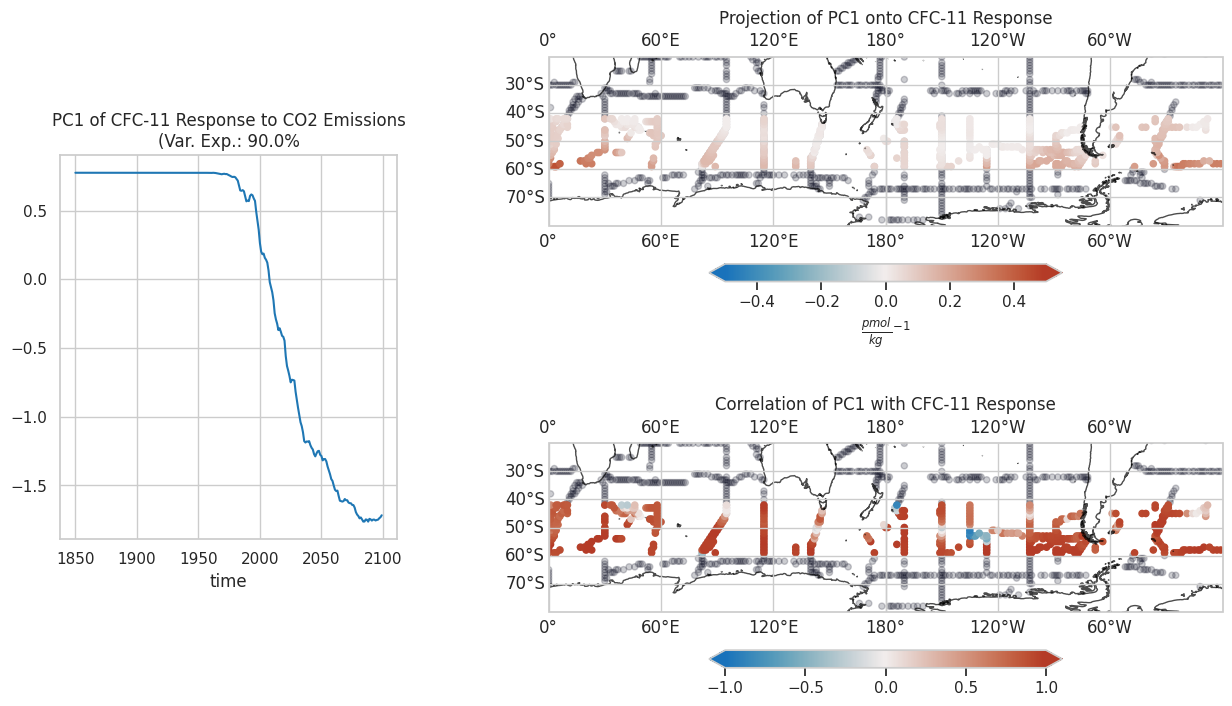

In [209]:
# Set up a custom GridSpec layout with controlled row heights
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(6, 2, width_ratios=[1, 2])
PC1_var = var_exp.round()[0]
# Line plot taking up the entire left column
line_ax = fig.add_subplot(gs[2:5, 0])  # Span both rows in the left column
line_ax.plot(xPC1.year, xPC1.values)  # Replace with your line plot data
line_ax.set_xlabel("time")
line_ax.set_ylabel("")
line_ax.set_title(f"PC1 of CFC-11 Response to CO2 Emissions\n(Var. Exp.: {PC1_var}%")

# Function to create a map with colorbar and scatter points
def plot_map(ax, data, title, boundaries, color_label):
    cmap = cmocean.tools.crop_by_percent(cmocean.cm.balance, 40, which='both')
    norm = BoundaryNorm(boundaries, ncolors=cmap.N)
    ax.set_global()
    # ax.set_extent([-180, 180, -21, -81], crs=ccrs.PlateCarree(central_longitude=180))
    ax.set_extent([-180, 180, -20, -80], crs=ccrs.PlateCarree(central_longitude=180))
    LON, LAT = np.meshgrid(cfc11_diff.lon, cfc11_diff.lat)
    # mesh = ax.pcolormesh(LON, LAT, data, 
                         # transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
    # mesh = ax.contourf(cfc11_diff.geolon, cfc11_diff.geolat, data, 
    #                      transform=ccrs.PlateCarree(), cmap=cmap, levels =boundaries)

    ax.scatter(Glon, Glat, c=Gdots, transform=ccrs.PlateCarree(), s=20, alpha=0.2)
    mesh = ax.scatter(LON[:], LAT[:], c=data[:], 
                      transform=ccrs.PlateCarree(), 
                      s=20, alpha=1, cmap=cmap, 
                      vmin = boundaries.min(), vmax = boundaries.max())
    ax.set_title(title)
    fig.colorbar(mesh, ax=ax, fraction=0.046, pad=0.1, extend = "both",
                 orientation="horizontal", label = color_label)
    ax.coastlines(resolution="50m", alpha=0.7)
    ax.set_aspect(1.5)
    ax.gridlines(draw_labels=True)

# Top and bottom maps in the second column
map_ax1 = fig.add_subplot(gs[0:3, 1], projection=ccrs.PlateCarree(central_longitude=180))
map_ax2 = fig.add_subplot(gs[3:, 1], projection=ccrs.PlateCarree(central_longitude=180))

# Plot the maps
boundaries = np.arange(-0.5, 0.6, 0.1)
boundaries[np.abs(boundaries) < 1e-8] = 0.0

plot_map(map_ax1, PC1_regression_results.slope.values, 
         "Projection of PC1 onto CFC-11 Response", boundaries, 
         r"$\frac{pmol}{kg}^{-1}$")

boundaries = np.arange(-1, 1.1, 0.2)
boundaries[np.abs(boundaries) < 1e-8] = 0.0

plot_map(map_ax2, PC1_regression_results.r_value.values, 
         "Correlation of PC1 with CFC-11 Response", boundaries, 
         None)

# Adjust layout to reduce space and ensure equal map sizes
plt.subplots_adjust(wspace=0.3, hspace=0.02)

In [210]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import numpy as np
from matplotlib.patches import Rectangle
from matplotlib.colors import BoundaryNorm

def plot_bootmedian_with_errorbars(ax, x, median, lower, upper, color='blue', label=""):
    ax.errorbar(x, median, yerr=[median - lower, upper - median], marker='o', color=color, ecolor=color, capsize=3, label=label)


def plot_cfc11_analysis(bottom_cfc11, masked_glodap_model, plot_median_with_errorbars, plot_median_quantiles, 
                       region={"lat": slice(-55, -45), "lon": slice(29, 31)},
                       obs_region={"lat": slice(-80, -30), "lon": slice(20, 40)},
                       figsize=(10, 5)):
    """
    Create a comprehensive visualization of CFC-11 data analysis with observation counts and time series.
    Uses a discrete colorbar with colors centered on integer values.
    """
    # Initialize GridSpec layout
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 2, width_ratios=[1.5, 2])
    
    # Observation count plot
    obs_ax = fig.add_subplot(gs[:, 0], projection=ccrs.PlateCarree())
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[1, 1], sharex=ax1)
    
    # Calculate observation counts
    obs_count = ((~np.isnan(bottom_cfc11)).sum("time")).sel(
        lat=slice(obs_region["lat"].start, obs_region["lat"].stop),
        lon=slice(obs_region["lon"].start, obs_region["lon"].stop)
    ).T
    obs_count = obs_count.where(obs_count > 0)
    
    # Create boundaries halfway between integers
    max_count = int(np.ceil(obs_count.max().values))
    min_count = int(np.floor(obs_count.min().values)) if not np.isnan(obs_count.min()) else 0
    
    # Create boundaries array (halfway between integers)
    boundaries = np.arange(min_count - 0.5, max_count + 1.5, 1)
    # Create the levels for the tick marks (integers)
    levels = np.arange(min_count, max_count + 1, 1)
    
    # Create the discrete colormap
    cmap = plt.cm.viridis
    norm = BoundaryNorm(boundaries, cmap.N)
    
    # Plot with discrete colorbar
    mesh = obs_ax.pcolormesh(
        obs_count.lon, 
        obs_count.lat, 
        obs_count.values,
        cmap=cmap,
        norm=norm,
        transform=ccrs.PlateCarree()
    )
    
    # Add colorbar
    cb = plt.colorbar(
        mesh,
        ax=obs_ax,
        orientation="vertical",
        label="# In-Situ CFC-11 Observations\nat Ocean Bottom",
        ticks=levels,  # use integer levels for tick marks
        boundaries=boundaries,  # use boundaries for color transitions
        pad=0.2,
        fraction=0.035,
        location="left"
    )
    
    # Configure map
    obs_ax.coastlines()
    gl = obs_ax.gridlines(draw_labels=True, alpha=0.3)
    gl.right_labels = False
    gl.top_labels = False
    
    # Add analysis region box
    lat_min, lat_max = region["lat"].start, region["lat"].stop
    lon_min, lon_max = region["lon"].start, region["lon"].stop
    obs_ax.add_patch(Rectangle(
        (lon_min, lat_min),
        lon_max - lon_min,
        lat_max - lat_min,
        edgecolor='red',
        facecolor='none',
        lw=1,
        alpha=0.3,
        transform=ccrs.PlateCarree()
    ))
    
    # Plot time series
    data_labels = ["CM4Xp125 forced", "CM4Xp125 control", "GLODAP"]
    data_colors = ["red", "blue", "green"]
    datasets = [masked_glodap_model.sel(region).isel(exp=i) for i in range(2)] + [bottom_cfc11.sel(region)]
    nboot = int(bottom_cfc11.sel(region).count(dim=["lat", "lon"]).max().values)
    
    for label, color, dataset in zip(data_labels, data_colors, datasets):
        data_selected = dataset        
        if label == "GLODAP":
            data_stats = bootstrap_spatial_stats_broadcast(data_selected, n_bootstrap=5000, flat_coords = ["lon", "lat"])
            data_stats = data_stats.sortby("time")                        
            median = data_stats.boot_mean
            lower = data_stats.ci_lower
            upper = data_stats.ci_upper
       
            plot_bootmedian_with_errorbars(ax1, data_stats.time, median, lower, upper,
                                     color=color, label=label)
            ax2.scatter(data_selected.time,
                       data_selected.count(dim=["lat", "lon"]),
                       color=color, label=label, marker="o", zorder=10)
        else:
            data_stats = bootstrap_spatial_stats(data_selected, n_bootstrap=5000, flat_coords = ["lon", "lat"])
            data_stats = data_stats.sortby("time")                        
            median = data_stats.boot_mean
            lower = data_stats.ci_lower
            upper = data_stats.ci_upper
            plot_median_quantiles(ax1, data_stats.time, median, lower, upper,
                                color=color, label=label)
    
    # Add model observation counts
    ax2.scatter(
        datasets[0].time,
        datasets[0].sel(region).count(dim=["lat", "lon"]).where(lambda x: x > 0),
        color="k",
        label="model"
    )
    
    # Finalize plot details
    ax1.set_ylabel('CFC-11 Concentration')
    ax1.legend()
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Number of Observations')
    ax2.legend()
    fig.tight_layout()
    
    return fig

/tmp/ipykernel_83930/1403940735.py:80: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(


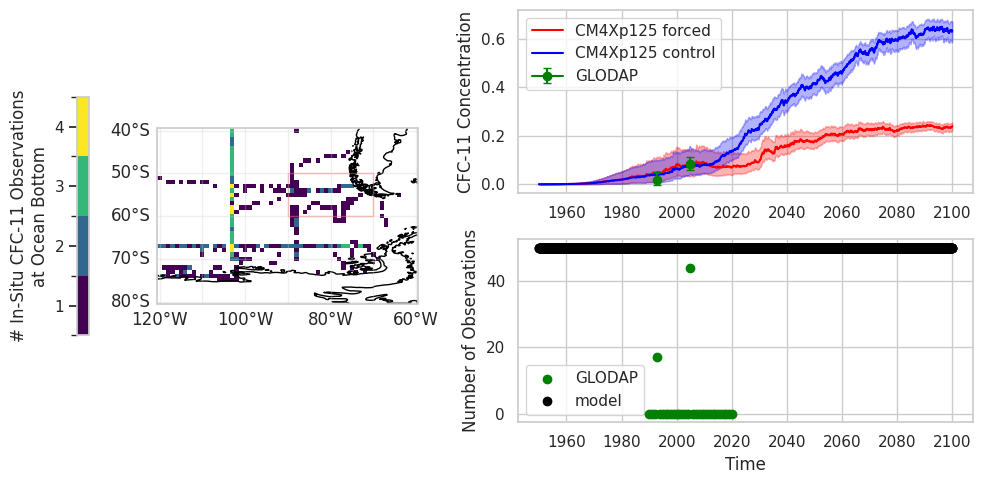

In [216]:
region={"lat": slice(-60, -50), "lon": slice(-90, -70)}
obs_region={"lat": slice(-80, -40), "lon": slice(-120, -60)}

fig = plot_cfc11_analysis(
    bottom_cfc11=bottom_cfc11,
    masked_glodap_model=masked_cfcs,
    plot_median_with_errorbars=plot_bootmedian_with_errorbars,
    plot_median_quantiles=plot_median_quantiles, 
    region = region, 
    obs_region = obs_region
)
plt.show()